In [61]:
import pandas as pd
import numpy as np, os
from pathlib import Path
from sklearn import linear_model


df = pd.read_csv("data/HW4/heart.csv")
df.head()

X = np.array(df.iloc[:,:-1])
y = np.array(df.iloc[:,[-1]])

print(X.shape, y.shape)
np.random.seed(123)
idx = np.random.choice(303, 303, replace=False)
tr_idx, te_idx = idx[:200], idx[200:]

X_tr, y_tr = X[tr_idx], y[tr_idx]
X_te, y_te = X[te_idx], y[te_idx]

def normalize(mode, X_tr, X_te):
  if mode == "z":
    # z-score normalize
    X_tr_mu = np.mean(X_tr, axis=0, keepdims=True)
    X_tr_sig = np.std(X_tr, axis=0, keepdims=True)

    X_tr_ = (X_tr - X_tr_mu) / X_tr_sig
    X_te_ = (X_te - X_tr_mu) / X_tr_sig
    return X_tr_, X_te_
  elif mode == "min-max":
    # min-max 0-1 normalization
    X_tr_mi = np.min(X_tr, axis=0, keepdims=True)
    X_tr_ma = np.max(X_tr, axis=0, keepdims=True)
    X_tr_ = (X_tr - X_tr_mi) / (X_tr_ma - X_tr_mi)
    X_te_ = (X_te - X_tr_mi) / (X_tr_ma - X_tr_mi)
    return X_tr_, X_te_
  else:
    return X_tr, X_te

def test_err(reg: linear_model.LogisticRegression, X, y):
  y_hat = reg.predict(X)
  err = np.not_equal(y_hat, y.flatten())
  return np.sum(err)

def compute_loss_with_bias(w, X, y):
  terms = np.log(1 + np.exp(-y * X @ w))
  assert(terms.shape == y.shape)
  return np.sum(terms) / len(X)

def compute_loss(reg: linear_model.LogisticRegression, X, y):
  X_prime = np.hstack((X, np.ones((len(X), 1))))
  w_prime = np.hstack((reg.coef_.flatten(), reg.intercept_.reshape((1,)))).reshape((-1, 1))
  wx_b = reg.decision_function(X)
  log_terms = np.log(1 + np.exp(-y.flatten() * wx_b.flatten()))
  return np.sum(log_terms) / len(X)

print(X_tr.shape, y_tr.shape, X_te.shape, y_te.shape)

def experiment(mode):
  print(f"*** Using {mode} Normalization")
  X_tr_, X_te_ = normalize(mode, X_tr, X_te)
  reg = linear_model.LogisticRegression(penalty=None, random_state = 123).fit(X_tr_, y_tr.flatten())
  print(f"*** With random state {reg.random_state}")
  w, b = reg.coef_, reg.intercept_
  print("\tw: ", np.round(w, 4).flatten())
  print("\tb: ", np.round(b, 4))

  print(f"=== Testing ===")
  err = test_err(reg, X_te_, y_te)  
  print(f"\tError Rate: {np.sum(err)}/{len(y_te)}={np.sum(err)/len(y_te):0.4f}")
  
  tr_loss = compute_loss(reg, X_tr_, y_tr)
  te_loss = compute_loss(reg, X_te_, y_te)
  print(f"\tTrain Loss: {tr_loss}, Test Loss: {te_loss}")

  print()
  print("-"*50)
  print()
  return tr_loss, te_loss

(303, 13) (303, 1)
(200, 13) (200, 1) (103, 13) (103, 1)


In [62]:
tr_loss, te_loss = experiment("min-max")

*** Using min-max Normalization
*** With random state 123
	w:  [-0.0916 -2.3859  2.5735 -3.329  -3.3522  0.5152  0.6446  4.345  -0.9711
 -4.1391  1.8231 -3.505  -2.4696]
	b:  [2.4201]
=== Testing ===
	Error Rate: 13/103=0.1262
	Train Loss: 0.48666074465306, Test Loss: 0.5078976863316779

--------------------------------------------------



In [71]:
import tqdm

def compute_gradient(w, X, y):
  y_hat = 1 / (1 + np.exp(-y * X @ w))
  wrong_prob = 1 - y_hat
  matrix = y * X * wrong_prob
  return np.mean(matrix, axis=0).reshape((-1, 1))

def experiment_coordinate(mode, thresh, lr):
  print(f"*** Using {mode} Normalization, thresh {thresh:0.5f}")
  np.random.seed(123)
  X_tr_, X_te_ = normalize(mode, X_tr, X_te)
  n_tr, n_te = X_tr_.shape[0], X_te_.shape[0]
  X_tr_, X_te_ = np.hstack((X_tr_, np.ones((n_tr, 1)))), np.hstack((X_te_, np.ones((n_te, 1))))

  y_tr_, y_te_ = y_tr.reshape((-1, 1)), y_te.reshape((-1, 1))

  w = np.random.normal(size=(X_tr_.shape[1], 1))
  losses = [compute_loss_with_bias(w, X_tr_, y_tr_)]
  te_losses = [compute_loss_with_bias(w, X_te_, y_te_)]
  for i in tqdm.tqdm(range(10000)):
    gradient = compute_gradient(w, X_tr_, y_tr_)
    gradient_norm = np.linalg.norm(gradient.flatten())
    if gradient_norm <= thresh:
      print(f"Breaking on iteration [{i}]")
      break
    idx_big = np.argmax(np.abs(gradient).flatten())
    sign = np.sign(gradient[idx_big,0])
    w[idx_big,0] += sign * gradient_norm * lr
    losses.append(compute_loss_with_bias(w, X_tr_, y_tr_))
    te_losses.append(compute_loss_with_bias(w, X_te_, y_te_))

  print()
  print("-"*50)
  print()
  return w, losses, te_losses, X_tr_, X_te_

*** Using min-max Normalization, thresh 0.20000


 78%|███████▊  | 7790/10000 [00:00<00:00, 17108.73it/s]

Breaking on iteration [7790]

--------------------------------------------------



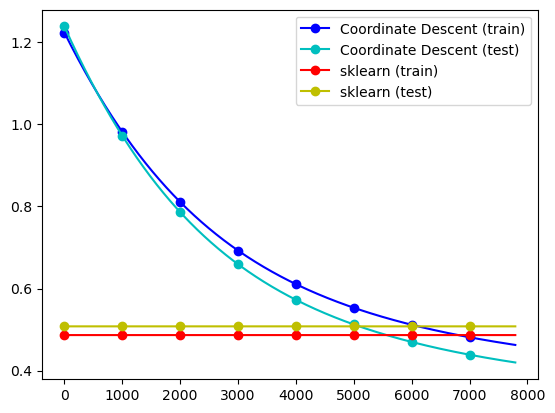

In [72]:
w, losses, te_losses, X_tr_, X_te_ = experiment_coordinate("min-max", thresh = 0.2, lr = 1e-3)

import matplotlib.pyplot as plt

plt.plot(np.arange(0, len(losses)), losses, "bo-", markevery=1000, label = "Coordinate Descent (train)")
plt.plot(np.arange(0, len(losses)), te_losses, "co-", markevery=1000, label = "Coordinate Descent (test)")
plt.plot(np.arange(0, len(losses)), np.ones(len(losses)) * tr_loss, "ro-", markevery=1000, label = "sklearn (train)")
plt.plot(np.arange(0, len(losses)), np.ones(len(losses)) * te_loss, "yo-", markevery=1000, label = "sklearn (test)")
plt.legend()